<a href="https://colab.research.google.com/github/SatyamPawale/COMPUTER-VISION/blob/main/Auto_Grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np


In [ ]:
class Node:
    def __init__(self, scalar, _children=(), _op='', name=''):
        self.scalar = scalar
        self.grad = 0.0
        self.name = name
        self._backward = lambda: None  # function to backprop
        self._prev = set(_children)    # child nodes
        self._op = _op

    def __repr__(self):
        return f"Node(name={self.name}, scalar={self.scalar}, grad={self.grad})"

    # Addition
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.scalar + other.scalar, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    # Multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.scalar * other.scalar, (self, other), '*')

        def _backward():
            self.grad += other.scalar * out.grad
            other.grad += self.scalar * out.grad

        out._backward = _backward
        return out

    # Power
    def __pow__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.scalar ** other.scalar, (self, other), '**')

        def _backward():
            x = self.scalar
            y = other.scalar
            out_val = out.scalar
            self.grad += y * (x ** (y - 1)) * out.grad
            if x > 0:
                other.grad += out_val * np.log(x) * out.grad
            else:
                other.grad += 0

        out._backward = _backward
        return out

    def exp(self):
        x = self.scalar
        out = Node(np.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.scalar * out.grad

        out._backward = _backward
        return out

    # Sigmoid
    def sigmoid(self):
        x = self.scalar
        sig = 1 / (1 + np.exp(-x))
        out = Node(sig, (self,), 'sigmoid')

        def _backward():
            self.grad += sig * (1 - sig) * out.grad

        out._backward = _backward
        return out

    # Tanh
    def tanh(self):
        x = self.scalar
        t = np.tanh(x)
        out = Node(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t * t) * out.grad

        out._backward = _backward
        return out

    # ReLU
    def relu(self):
        x = self.scalar
        out = Node(x if x > 0 else 0.0, (self,), 'relu')

        def _backward():
            self.grad += (1.0 if x > 0 else 0.0) * out.grad

        out._backward = _backward
        return out

    # Logarithm
    def log(self):
        x = self.scalar
        out = Node(np.nan if x < 0 else np.log(x), (self,), 'log')

        def _backward():
            if x > 0:
                self.grad += (1 / x) * out.grad
            else:
                self.grad += 0

        out._backward = _backward
        return out

    # Square root
    def sqrt(self):
        assert self.scalar > 0, "No complex numbers allowed"
        x = self.scalar
        out = Node(np.sqrt(x), (self,), 'sqrt')

        def _backward():
            self.grad += (1 / (2 * np.sqrt(x))) * out.grad

        out._backward = _backward
        return out

    # Cosine
    def cos(self):
        x = self.scalar
        out = Node(np.cos(x), (self,), 'cos')

        def _backward():
            self.grad += -np.sin(x) * out.grad

        out._backward = _backward
        return out

    # Sine
    def sin(self):
        x = self.scalar
        out = Node(np.sin(x), (self,), 'sin')

        def _backward():
            self.grad += np.cos(x) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        # topological order of the visited children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

def trace_nodes(node):
    nodes = []
    def build(v):
        if v not in nodes:
            nodes.insert(0, v)
            for child in v._prev:
                build(child)
    build(node)
    return nodes

def print_graph(root):
    nodes = trace_nodes(root)
    for n in nodes:
        print(n)






In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_graph(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any scalar in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | scalar %s | grad %s }" % (n.name, n.scalar, n.grad), shape='record')
    if n._op:
      # if this scalar is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Node(2.0, name='a')
b = Node(-3.0, name='b')
c = Node(10.0, name='c')

# Manually create intermediate nodes to track the computation
#Z_t1 = a * b; Z_t1.name = 'Z_t1'
#Z_t2 = Z_t1 + c; Z_t2.name = 'Z_t2'
expr = (a + b + c**2).sqrt() + (a + b + c**2).log() + (a + b + c**2)/(b * c**2)

# Compute gradients
expr.backward()

# Print values and gradients
print(c)      # Node(name=c, scalar=10.0, grad=1.0)
print(a)      # Node(name=a, scalar=2.0, grad=-3.0)
print(b)      # Node(name=b, scalar=-3.0, grad=2.0)
print(expr)   # Node(name=Z_t1, scalar=-6.0, grad=1.0)
#print(Z_t2)   # Node(name=Z_t2, scalar=4.0, grad=1.0)

print("\n--- Using compact expression ---")
# Reset gradients
a.grad = 0
b.grad = 0
c.grad = 0

# Compact expression
Z = a * b + c
Z.name = 'Z'
Z.backward()

Node(name=c, scalar=10.0, grad=1.2063913506127475)
Node(name=a, scalar=2.0, grad=0.057019567530637374)
Node(name=b, scalar=-3.0, grad=-0.05298043246936262)
Node(name=, scalar=14.214994221200788, grad=1.0)

--- Using compact expression ---


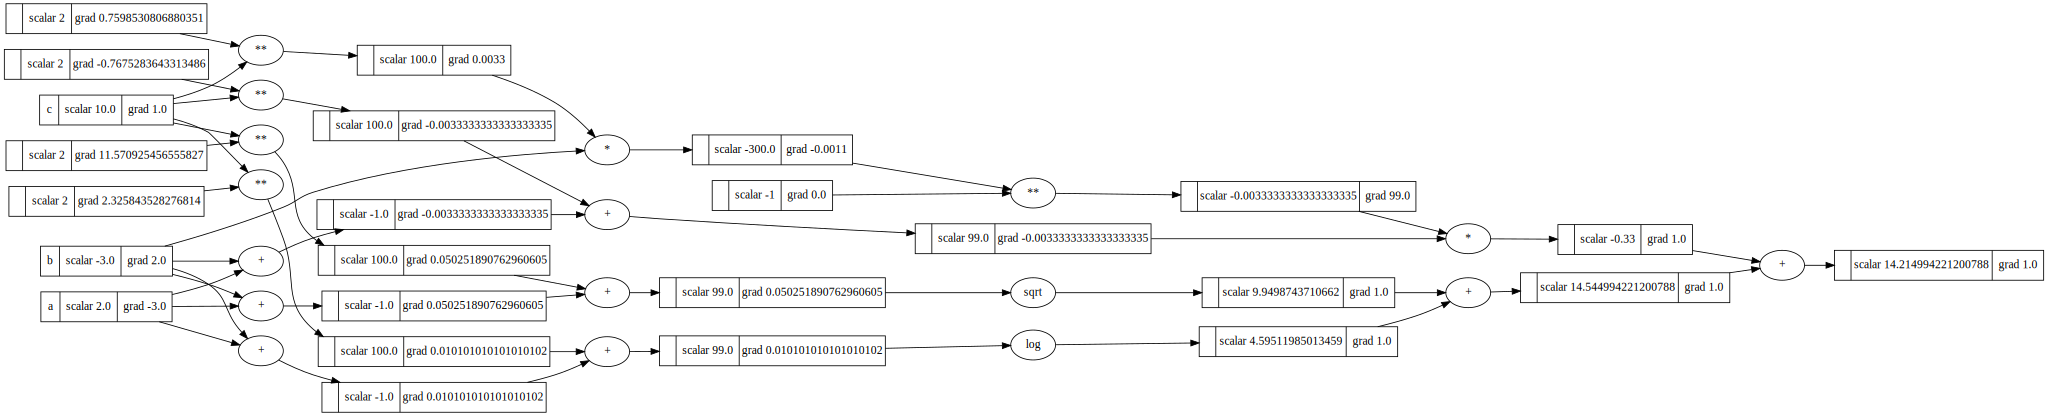

In [ ]:
draw_graph(expr)

In [ ]:
# Define variables
w0 = Node(0.5, name='w0')
w1 = Node(1.0, name='w1')

# Input and target values
x = [1.0, 2.0, 3.0]
y = [2.0, 4.0, 6.0]

# Step-by-step intermediates for each term
# Term 1: (w0 + w1*x1 - y1)^2
Z1_1 = w1 * x[0]
Z1_1.name = 'Z1_1'
Z1_2 = w0 + Z1_1
Z1_2.name = 'Z1_2'
Z1_3 = Z1_2 - y[0]
Z1_3.name = 'Z1_3'
T1 = Z1_3 ** 2
T1.name = 'T1'

# Term 2: (w0 + w1*x2 - y2)^2
Z2_1 = w1 * x[1]
Z2_1.name = 'Z2_1'
Z2_2 = w0 + Z2_1
Z2_2.name = 'Z2_2'
Z2_3 = Z2_2 - y[1]
Z2_3.name = 'Z2_3'
T2 = Z2_3 ** 2
T2.name = 'T2'

# Term 3: (w0 + w1*x3 - y3)^2
Z3_1 = w1 * x[2]
Z3_1.name = 'Z3_1'
Z3_2 = w0 + Z3_1
Z3_2.name = 'Z3_2'
Z3_3 = Z3_2 - y[2]
Z3_3.name = 'Z3_3'
T3 = Z3_3 ** 2
T3.name = 'T3'

# Full expression B
B = T1 + T2 + T3
B.name = 'B'

# Backpropagate
B.backward()

# Print results
print("Value of B:", B.scalar)
print("Gradients:")
print("dB/dw0 =", w0.grad)
print("dB/dw1 =", w1.grad)

Value of B: 8.75
Gradients:
dB/dw0 = -9.0
dB/dw1 = -22.0


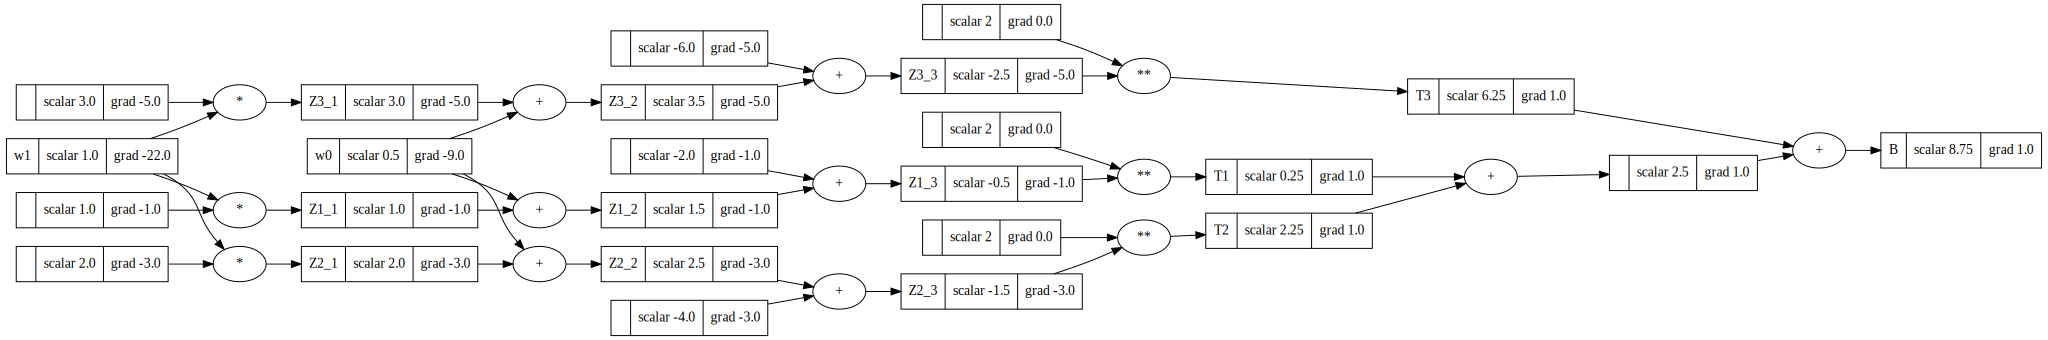

In [ ]:
draw_graph(B)